In [6]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr

In [7]:
def create_test_image(size=256):
    """Create a test image with different intensity regions."""
    img = np.zeros((size, size))

    # Create background
    img += 0.3

    # Add shapes
    center = size // 2
    y, x = np.ogrid[-center:size-center, -center:size-center]

    # Add circle
    mask_circle = x*x + y*y <= (size//4)**2
    img[mask_circle] = 0.7

    # Add rectangle
    img[size//4:size//2, size//4:3*size//4] = 0.9

    return img

def add_salt_and_pepper(image, prob):
    """Add salt and pepper noise."""
    noisy = image.copy()
    # Salt
    salt_mask = np.random.random(image.shape) < prob/2
    noisy[salt_mask] = 1
    # Pepper
    pepper_mask = np.random.random(image.shape) < prob/2
    noisy[pepper_mask] = 0
    return noisy

def standard_median_filter(image, kernel_size):
    """Apply standard median filter."""
    from scipy import ndimage
    return ndimage.median_filter(image, size=kernel_size)

def adaptive_median_filter(image, initial_window=3, max_window=7):
    """
    Apply adaptive median filter.
    Level A: Check if median is impulse (too high/low)
    Level B: Check if current pixel is impulse
    """
    padded = np.pad(image, max_window//2, mode='symmetric')
    result = np.copy(image)

    rows, cols = image.shape

    for i in range(rows):
        for j in range(cols):
            window_size = initial_window
            while window_size <= max_window:
                # Extract window
                r = window_size // 2
                window = padded[i:i+window_size, j:j+window_size]

                # Calculate statistics
                z_med = np.median(window)
                z_min = np.min(window)
                z_max = np.max(window)
                z_xy = image[i, j]

                # Level A: Check if median is impulse
                A1 = z_med - z_min
                A2 = z_med - z_max

                if A1 > 0 and A2 < 0:
                    # Level B: Check if current pixel is impulse
                    B1 = z_xy - z_min
                    B2 = z_xy - z_max

                    if B1 > 0 and B2 < 0:
                        result[i, j] = z_xy  # Not an impulse
                    else:
                        result[i, j] = z_med  # Is an impulse
                    break
                else:
                    # Increase window size if at max return median
                    if window_size == max_window:
                        result[i, j] = z_med
                        break
                    window_size += 2

    return result



In [8]:
# Create and process images
image_size = 256
noise_prob = 0.25
standard_kernel_size = 3

# Create original and noisy images
original = create_test_image(image_size)
noisy = add_salt_and_pepper(original, noise_prob)

# Apply filters
median_filtered = standard_median_filter(noisy, standard_kernel_size)
adaptive_median_filtered = adaptive_median_filter(noisy)

# Calculate PSNR values
psnr_noisy = psnr(original, noisy, data_range=1.0)
psnr_median = psnr(original, median_filtered, data_range=1.0)
psnr_adaptive = psnr(original, adaptive_median_filtered, data_range=1.0)



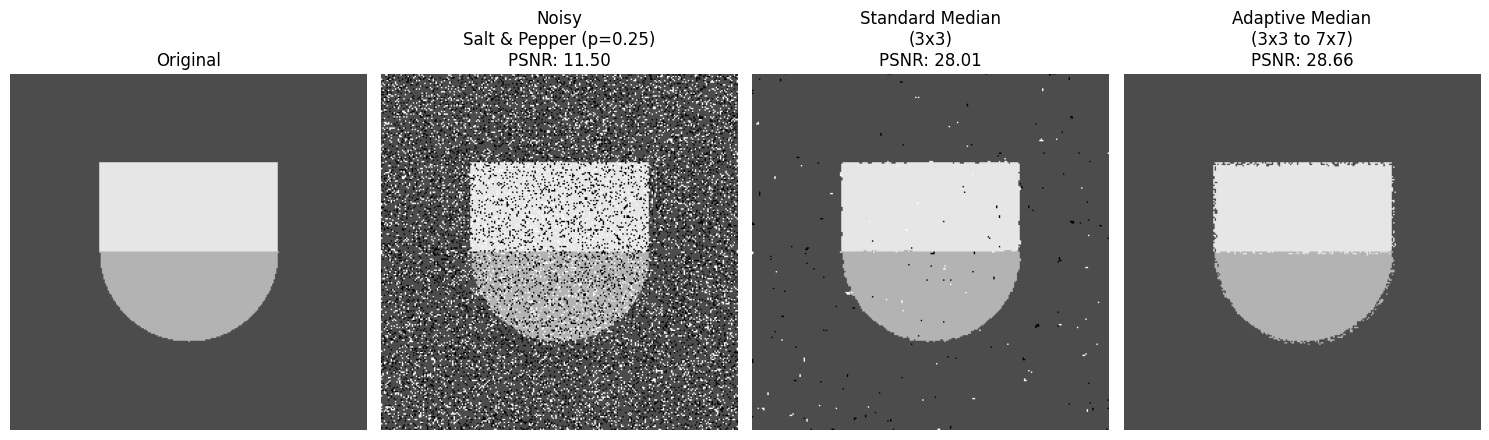

In [9]:
# Visualization
plt.figure(figsize=(15, 5))

# Original image
plt.subplot(141)
plt.imshow(original, cmap='gray', vmin=0, vmax=1)
plt.title('Original')
plt.axis('off')

# Noisy image
plt.subplot(142)
plt.imshow(noisy, cmap='gray', vmin=0, vmax=1)
plt.title(f'Noisy\nSalt & Pepper (p={noise_prob})\nPSNR: {psnr_noisy:.2f}')
plt.axis('off')

# Standard median filter
plt.subplot(143)
plt.imshow(median_filtered, cmap='gray', vmin=0, vmax=1)
plt.title(f'Standard Median\n({standard_kernel_size}x{standard_kernel_size})\nPSNR: {psnr_median:.2f}')
plt.axis('off')

# Adaptive median filter
plt.subplot(144)
plt.imshow(adaptive_median_filtered, cmap='gray', vmin=0, vmax=1)
plt.title(f'Adaptive Median\n(3x3 to 7x7)\nPSNR: {psnr_adaptive:.2f}')
plt.axis('off')

plt.tight_layout()
plt.show()



In [10]:
# Print detailed analysis
print("\nFilter Performance Analysis:")
print(f"Noisy Image PSNR: {psnr_noisy:.2f}")
print(f"Standard Median Filter PSNR: {psnr_median:.2f}")
print(f"Adaptive Median Filter PSNR: {psnr_adaptive:.2f}")


Filter Performance Analysis:
Noisy Image PSNR: 11.50
Standard Median Filter PSNR: 28.01
Adaptive Median Filter PSNR: 28.66
